In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

nr_neurons = 441
total_receptors = 256
delta_t = 0.2

weights = pd.read_csv("pre_post_wfs_per_set51.csv")
post_weights = weights.iloc[nr_neurons: ,]

PATTERN MATCH

One way to track how exactly the model is learning is to check how well neurons are specialising in matching receptor outputs. This can be visualised by plotting stimulus-specific receptor outputs and neuron feed-forward weights as overlapping graphs, where each receptor can be compared to its corresponding feed-forward value. From an initial state of random feed-forward values in range from zero to one, it can be observed how over training time most feed-forward wights drop to match the zero value of most of the receptor outputs, save for the peaks where receptors have produced some incresed output specific to the stimulus location. As groups of neural units learn to specialise in some specific stimulus receptor output pattern, they become more strongly responsive to this stimulus and less responsive to stimuli further away.

The section bollow uses the external input function to determine the highest and lowest selected stimulus pattern matching neurons and plots the receptor output to feed-forward weight graphs for easy comparisson. Heatmap bellow shows the whole neural field response for single time step application (not lateral contributions) based only on external input value

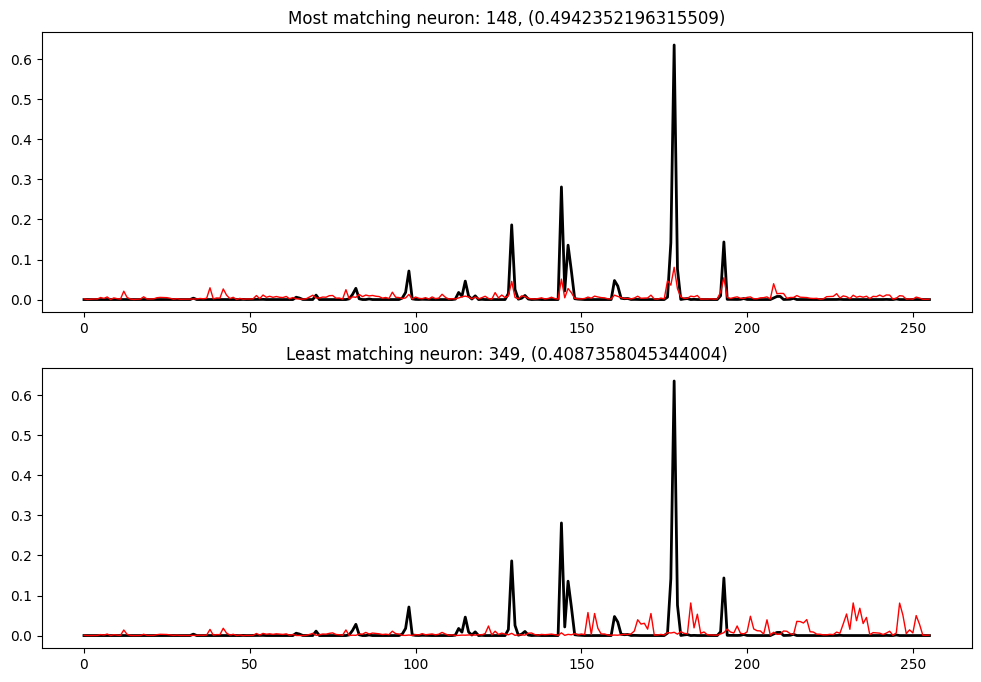

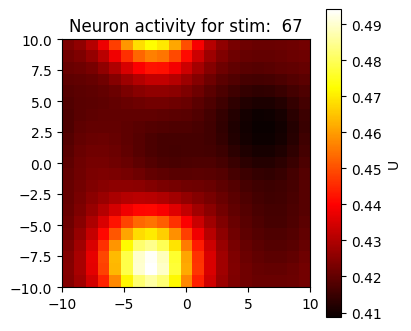

In [5]:
receptor_outputs = pd.read_csv("receptor_outputs_1.csv")
stim = 67
current_stim_outputs = receptor_outputs[receptor_outputs["Stimulus_Index"] == stim]
outputs = current_stim_outputs["Output"].values
external_input = np.zeros(nr_neurons)
holding_u = np.zeros(nr_neurons)

for x in range(nr_neurons):
    input_match = outputs - post_weights.iloc[x].values # take this away for next post 10 cycle
    weighted_diffs = np.abs(input_match) * outputs
    external_input[x] = 1 - (np.sum(weighted_diffs)) # sum to get a single value

sorted_by_match = np.argsort(external_input)
top_match = sorted_by_match[440]
bottom_match = sorted_by_match[0]
top_wf_values = post_weights.iloc[top_match,:].values
bottom_wf_values = post_weights.iloc[bottom_match,:].values

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(range(256), outputs, 'k-', linewidth=2, label='Receptor Outputs')
plt.plot(range(256), top_wf_values, 'r-', linewidth=1, label='Wf')
plt.title(f'Most matching neuron: {top_match}, ({external_input[top_match]})')

plt.subplot(2, 1, 2)
plt.plot(range(256), outputs, 'k-', linewidth=2, label='Receptor Outputs')
plt.plot(range(256), bottom_wf_values, 'r-', linewidth=1, label='Wf')
plt.title(f'Least matching neuron: {bottom_match}, ({external_input[bottom_match]})')

# to see "U" response after training i only need to have the external input and see how much
# the neurons respond -> ne dacay, no lateral contributions (basline activity is 0).
plt.figure(figsize=(4,4))
plt.imshow(external_input.reshape(21,21).T, extent=[-10, 10, -10, 10], cmap='hot', origin='lower')#, vmin=0.0, vmax=1)
plt.colorbar(label="U")
plt.title(f'Neuron activity for stim:  {stim}')

plt.show()

Here is the external input generated by every stimulus in the stimulation set for a selected neuron

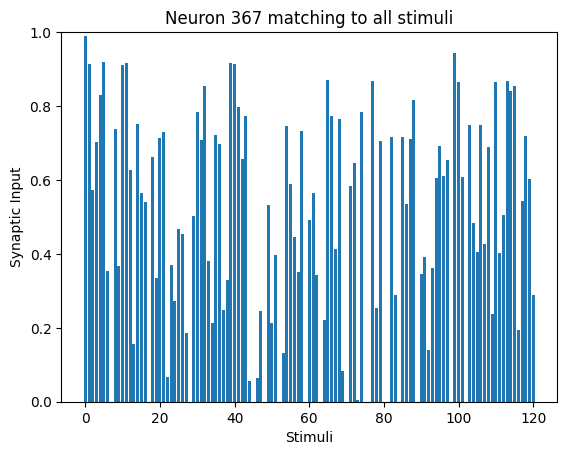

In [9]:
"""SYNAPTIC INPUTS FOR SINGLE NEURON"""
neuron = 367
holding = []

for i in range(121):
    current_stim_outputs = receptor_outputs[receptor_outputs["Stimulus_Index"] == i]
    outputs = current_stim_outputs["Output"].values

    input_diffs = (np.abs(outputs - post_weights.iloc[neuron].values) * outputs)
    holding.append(1 - (np.sum(input_diffs)))

plt.bar(range(121), holding)
plt.xlabel('Stimuli')
plt.ylabel('Synaptic Input')
plt.title(f'Neuron {neuron} matching to all stimuli')
plt.ylim(0, 1)
plt.show()

LATERAL CONTRIBUTIONS CHECK

To tune and verify lateral contribution parameters and proper FFT, this section investigates these dynamics. 
- Firstly, the cortical model is set up as in the main simulation, along with the necessary functions. 
- Lateral contribution parameters are visualised as heatmaps, based on a set seed region of activity in the middle of the cortical field.
- FFT is validated by visualising the expanded firing map used to handle periodic boundaries aswell as the heatmap of FFT results showing the mexican hat type response generated around the seed activity region
- Finally, the simulation is run with set activity regions and no other external input to isolate network dynamics. 

In [6]:
learning_window = 3.0 # learning window of one stimulus
tau_const = 1.0
delta_t = 0.2
gamma = 0.05
alpha = 0.1
Ke = 2.60
Ki = 1.80
vare = 2.2
vari = 15.0
total_receptors = 256

# Initiate Cortical Sheet
x_coords = np.linspace(-10,10, num = 21)
y_coords = np.linspace(-10,10, num = 21)
cortex_coords = [(i,j) for i in x_coords for j in y_coords]
cortex = pd.DataFrame(cortex_coords, columns=["X", "Y"])
# initial membrane potentials at 0 for no activity, except in the middle neurons
cortex["U"] = 0
center_neurons = [199, 219, 220, 221, 241]
for i in center_neurons:
    cortex.loc[i, "U"] = 0.5


""" FUNCTIONS """
def firing_function(x):
    return np.maximum(x, 0)

def external_input(match, outputs):
    input_diffs = np.abs(match)
    weighted_diffs = input_diffs * outputs # discard 0 value inputs, extra attention to output peaks
    external_input = 1 - (np.sum(weighted_diffs))
    return external_input

def create_distance_matrix(grid_size):
    # create -10,10 coordinate system, calculate distances
    ax = np.arange(-grid_size//2 + 1, grid_size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    distance_matrix = np.sqrt(xx**2 + yy**2)
    return distance_matrix

def create_weight_kernel(distance):
    ex_weights = Ke * np.exp(-(distance ** 2) / (2 * vare ** 2))
    inh_weights = Ki * np.exp(-(distance ** 2) / (2 * vari ** 2))
    lat_weights = ex_weights - inh_weights
    return lat_weights, ex_weights, inh_weights

# Create Distance Matrix (shape = cortex.shape)
distance_matrix = create_distance_matrix(21)

#distance_matrix = periodic_distance_matrix(cortex[['X', 'Y']].values, 21)
wl_kernel, _, _ = create_weight_kernel(distance_matrix)
_, we_kernel, _ = create_weight_kernel(distance_matrix)
_, _, wi_kernel = create_weight_kernel(distance_matrix)


def fft_lateral_contributions(firing_map, kernel):
    map_size = firing_map.shape[0]              # should be 21
    k_size = kernel.shape[0]                    # should be 21
    extended_map = np.tile(firing_map, (3, 3))  # should be 21*3 = 63 (63x63)
    padded_kernel = np.pad(kernel,[(map_size, extended_map.shape[0] - k_size - map_size)], mode='constant')

    map_fft = fft2(extended_map)
    kernel_fft = fft2(padded_kernel)
    result_fft = map_fft * kernel_fft
    result = np.real(ifft2(result_fft))
    result = fftshift(result)
    
    start = map_size -1
    end = extended_map.shape[0] - map_size -1
    result_region = result[start:end, start:end]

    # Normalise post convolution to scale lateral contributions in -1;1 boundaries
    max_value = np.max(np.abs(result_region))
    if max_value != 0:
        result_region /= max_value

    return result_region

-1.6056219981426667


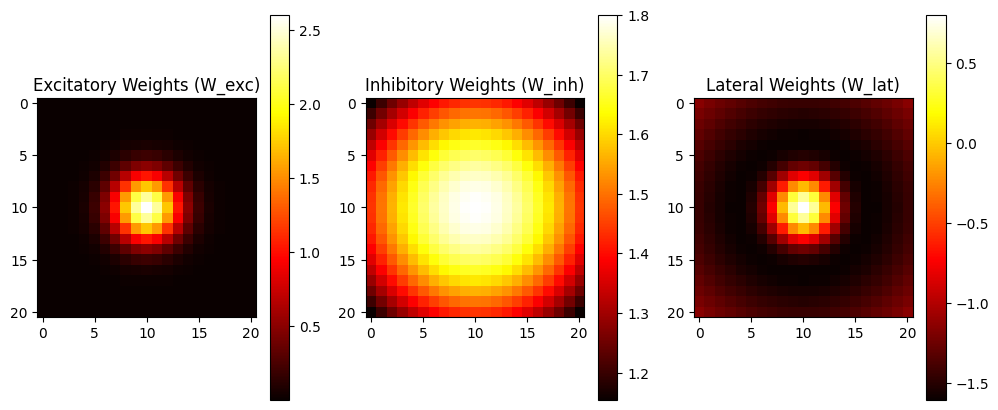

In [460]:
""" PLOTTING EXCITATION AND INHIBITION """
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(we_kernel, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Excitatory Weights (W_exc)")

plt.subplot(1, 3, 2)
plt.imshow(wi_kernel, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Inhibitory Weights (W_inh)")

plt.subplot(1, 3, 3)
plt.imshow(wl_kernel, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Lateral Weights (W_lat)")

print(np.min(wl_kernel))

RESULT

Variance values are selected based on single units of the created field: in this case x = y = 1. From this the excitation region is set to include a neighborhood of about 5-9 neurons (in the net lateral weights). Inhibition is based on the largest distance (>14) and is set slightly above to facilitate a single bump solution

Text(0.5, 1.0, 'Lateral connections')

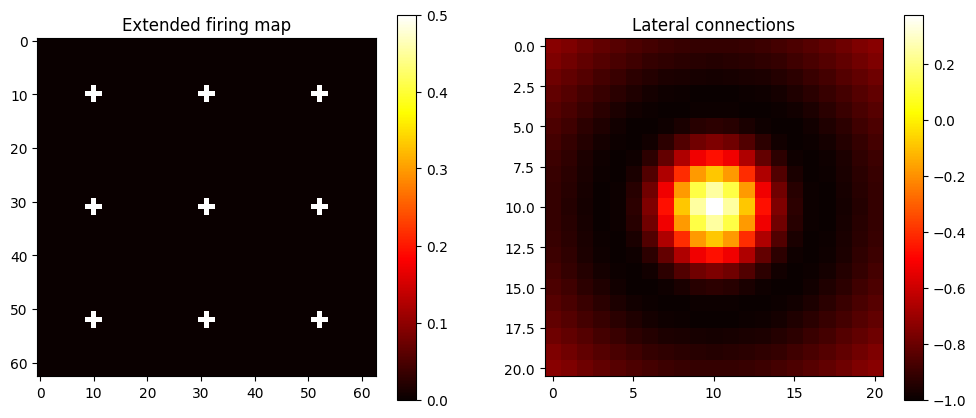

In [461]:
"""ENSURE FFT DONE CORRECTLY"""
firing = cortex["U"].values
firing_map = cortex["U"].values.reshape(21,21).T[::-1]
# reshaping creates the 2d shape, transposition (T) switches rows to columns
# and [::-1] reverses the order in which the columns are populated, so that the end map
# achieves the intended spatial relationships of the cortical sheet

result = fft_lateral_contributions(firing_map, wl_kernel)
extended = np.tile(firing_map, (3, 3))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(extended, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Extended firing map")

plt.subplot(1, 2, 2)
plt.imshow(result, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Lateral connections")

RESULT

The firing map is extended to use periodic boundaries and kernel is padded to match used firing map size. FFT results need to be shifted to filter out the correct region of interest.This is visualised and validated in the heatmaps - the seed activation region is producing net excitatory input, while rest of the neurons get inhibitory input

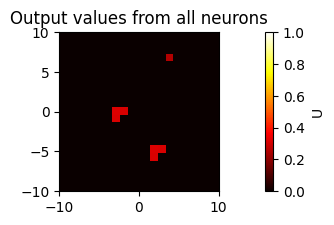

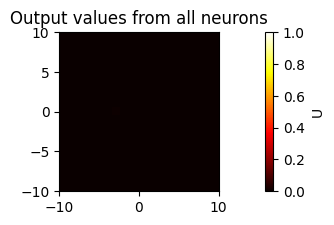

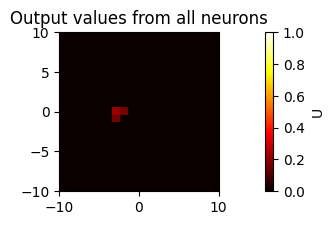

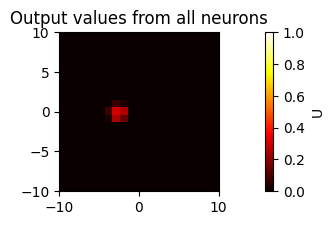

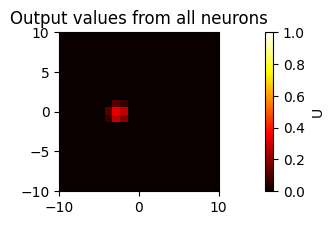

In [10]:
""" Numerical integration """
cortex["U"] = 0
cortex.loc[98, "U"] = 0.1
cortex.loc[97, "U"] = 0.1
cortex.loc[119, "U"] = 0.1

cortex.loc[311, "U"] = 0.5

cortex.loc[256, "U"] = 0.5
cortex.loc[257, "U"] = 0.5
cortex.loc[278, "U"] = 0.5

cortex.loc[156, "U"] = 0.5
cortex.loc[157, "U"] = 0.5
cortex.loc[178, "U"] = 0.5

# Initialize recording arrays
num_steps = int(learning_window / delta_t)
recorded_U = np.zeros((len(cortex), num_steps))  # Adjust size to record every 5th iteration
holding_U = np.zeros(len(cortex))
#lambda_relax = 0.1

def simulation():
    for time_step in range(num_steps):
        firing = cortex["U"].values
        firing_map = np.vectorize(firing_function)(firing).reshape(21,21).T[::-1]
        lat_contributions = fft_lateral_contributions(firing_map, wl_kernel)[::-1].T.flatten()

        for x in range(len(cortex)):
            # updating all neuron membrane potential values one by one
            integral = lat_contributions[x]
            previous_u = cortex.loc[x, "U"]
            # holding_U[x] = (1 - lambda_relax) * previous_u + lambda_relax * (-previous_u + integral) # soother u transitions
            holding_U[x] = previous_u + delta_t * (-previous_u + integral)
        
        # Apply the updates after processing all neurons
        cortex["U"] = holding_U
        # Record
        recorded_U[:, time_step] = cortex["U"].values

    return recorded_U


recorded_test = simulation()
counter = 0
for i in range(0, 15, 3):
    counter += 1
    filtered = recorded_test[:, i]
    heatmap_values = filtered.reshape(21, 21).T  # Heat maps are plotted withput the need to reverse the order
    
    X, Y = np.meshgrid(x_coords, y_coords)
    plt.figure(figsize=(12,12))
    plt.subplot(5, 1, counter)
    plt.imshow(heatmap_values, extent=[-10, 10, -10, 10], cmap='hot', origin='lower', vmin=0.0, vmax=1)
    plt.colorbar(label="U")
    plt.title('Output values from all neurons')
    plt.show()

# reset cortex
# cortex["U"] = 0
# center_neurons = [199, 219, 220, 221, 241]
# for i in center_neurons:
#     cortex.loc[i, "U"] = 0.5

RESULT

Numerical integration considers decay term (previous u) and lateral contributions, the aim is to achieve a stable bump over the learning window. A single seed region (0.5 initial U for neurons 199, 219, 220, 221 and 241) is handled well by the set lateral connection parameters - remains relatively stable over time, bump shape stays consistent.

Multiple seed regions of various activation values permit only a single bump of activity after around 12-15 iterrations (so the learning window is set to 15 iterrations)

Parameters used in reference article:

Ke = 4.00

Ki = 1.20

vare = 1.0

vari = 15.0

PARAMETERS USED FOR THIS MODEL BASED ON ANALYSIS:

single bump still prevails, but initially entire neural field is silenced.

Ke = 2.60

Ki = 1.80

vare = 2.2

vari = 15.0